In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/FINN

/content/gdrive/MyDrive/FINN


In [ ]:
while True:
  pass

In [ ]:
ls

'American Option Exercise Boundary.ipynb'
 american_put_script.sh
 american_results/
 calibration_summary.csv
'Copy of Copy of Copy of Copy of run.ipynb'
'Copy of Copy of Copy of run.ipynb'
'Copy of Copy of run.ipynb'
'Copy of run.ipynb'
'FINN Result Analysis.ipynb'
 gbm_american_put_trained_models/
 gbm_call_trained_models/
 gbm_gamma_call_trained_models/
 gbm_gamma_put_trained_models/
 gbm_put_trained_models/
 gbm_results/
 gbm_results_gamma/
 heston_analytical.py
 heston_call_trained_models/
 heston_put_trained_models/
 heston_results/
 plot_american_put.py
 plot_black_scholes_gamma.py
 plot_black_scholes.py
 plot_heston_gamma.py
 plot_heston.py
 pnl_mjd_tc_0.csv
 pnl_mjd_tc_0p5.csv
 pnl_mjd_tc_1.csv
 pnl_mjd_tc_2.csv
 pnl_real_spx_gbm_robustness.csv
 pnl_tc_0.csv
 pnl_tc_0p5.csv
 pnl_tc_1.csv
 pnl_tc_2.csv
 pricing_greeks_errors.csv
'robustness tests'/
 run_american_put.py
 run_black_scholes_gamma.py
 run_black_scholes.py
 run_heston.py
 running_script.sh
'run - real world robustne

In [ ]:
import os
from typing import Tuple, Dict, List
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.auto import tqdm

OPTION_TYPE = "call"
R = 0.0

MAIN_TTM_DAYS  = 90
HEDGE_TTM_DAYS = 30
WINDOW_DAYS    = 21
H = 1.0 / 250.0

TC_LEVELS = (0.0, 0.01, 0.02)
STOCK_TC  = 0.00

SEEDS = [413, 491, 492, 493, 494, 495, 496, 497, 498, 499]

MU_ALPHA_DEFAULT = 0.058
S0_DEFAULT = 100.0
N_PATHS_DEFAULT = 50_000
SEED_DEFAULT = 413

SPX_CSV = "spx_daily.csv"

OUT_CALIB = "./mc_calibration_six.csv"
OUT_PNL   = "./mc_pnl_six.csv"

TEST_YEARS = [2008, 2011, 2020]
REGIME_BY_YEAR = {
    2008: "Crisis", 2020: "Crisis",
    2011: "Moderate", 2015: "Moderate",
    2013: "Bull", 2017: "Bull",
}

SIZING_SIGMA = "train"

_SQRT_2PI = np.sqrt(2.0 * np.pi)

def norm_pdf(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=np.float64)
    return np.exp(-0.5 * x * x) / _SQRT_2PI

def norm_cdf(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=np.float64)
    t = 1.0 / (1.0 + 0.2316419 * np.abs(x))
    b1, b2, b3, b4, b5 = 0.319381530, -0.356563782, 1.781477937, -1.821255978, 1.330274429
    poly = (((b5 * t + b4) * t + b3) * t + b2) * t + b1
    cdf_approx = 1.0 - norm_pdf(x) * poly * t
    return np.where(x >= 0, cdf_approx, 1.0 - cdf_approx)

def bsm_batch_price_delta_gamma(S, K, tau, r, sigma, call=True):
    """Vectorized BSM price/delta/gamma with broadcasting."""
    S = np.asarray(S, dtype=np.float64)
    K = np.asarray(K, dtype=np.float64)
    tau = np.asarray(tau, dtype=np.float64)
    eps = 1e-12
    sqrtT = np.sqrt(np.maximum(tau, eps))
    sig = np.maximum(sigma, eps)

    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = (np.log(np.maximum(S, eps) / np.maximum(K, eps)) + (r + 0.5 * sig * sig) * tau) / (sig * sqrtT)
    d2 = d1 - sig * sqrtT
    Phi_d1 = norm_cdf(d1)
    Phi_d2 = norm_cdf(d2)
    phi_d1 = norm_pdf(d1)

    if call:
        price = S * Phi_d1 - K * np.exp(-r * tau) * Phi_d2
        delta = Phi_d1
    else:
        price = K * np.exp(-r * tau) * norm_cdf(-d2) - S * norm_cdf(-d1)
        delta = Phi_d1 - 1.0

    gamma = phi_d1 / (np.maximum(S, eps) * sig * sqrtT)

    expired = tau <= 0
    if np.any(expired):
        if call:
            price = np.where(expired, np.maximum(S - K, 0.0), price)
            delta = np.where(expired, (S > K).astype(np.float64), delta)
        else:
            price = np.where(expired, np.maximum(K - S, 0.0), price)
            delta = np.where(expired, -(S < K).astype(np.float64), delta)
        gamma = np.where(expired, 0.0, gamma)

    return price, delta, gamma

def var_cvar(x: np.ndarray, alpha: float):
    """Left-tail VaR/CVaR at level alpha (e.g., 0.95 or 0.99)."""
    x = np.asarray(x, dtype=np.float64)
    q = np.quantile(x, 1.0 - alpha)
    tail = x[x <= q]
    cvar = tail.mean() if tail.size > 0 else q
    return float(q), float(cvar)

def _sigma_tag(s: float) -> str:
    x = round(float(s), 3)
    if abs(x - 0.174) < 1e-9 or abs(x - 0.176) < 1e-9:
        x = 0.175
    if abs(x - 0.185) < 1e-9:
        x = 0.186
    return f"{x:.3f}"

def _model_paths_for(tag: str, seed: int) -> Tuple[str, str]:
    if tag == "0.175":
        d_base = os.path.join(".", "gbm_call_trained_models")
        g_base = os.path.join(".", "gbm_gamma_call_trained_models", "30 Days")
    else:
        d_base = os.path.join(".", "robustness tests")
        g_base = os.path.join(".", "robustness tests")
    delta_path = os.path.join(d_base, f"gbm_european_{OPTION_TYPE}_{tag}_{seed}.h5")
    dgamma_path = os.path.join(g_base, f"gbm_european_{OPTION_TYPE}_{tag}_{seed}_{HEDGE_TTM_DAYS}.h5")
    return delta_path, dgamma_path

def _load_finn_models_for_tag(tag: str):
    tf.keras.backend.set_floatx('float64')
    fd, fdg = [], []
    for s in SEEDS:
        p_delta, p_dg = _model_paths_for(tag, s)
        fd.append(tf.keras.models.load_model(p_delta, compile=False))
        fdg.append(tf.keras.models.load_model(p_dg, compile=False))
    return fd, fdg

class FinnEnsemble:
    def __init__(self, models: List[tf.keras.Model]):
        self.models = models

    def predict_batch(self, S, K, tau):
        pxs, des, gas = [], [], []
        for m in self.models:
            px, de, ga = finn_batch_price_delta_gamma(m, S, K, tau)
            pxs.append(px); des.append(de); gas.append(ga)
        return np.mean(pxs, axis=0), np.mean(des, axis=0), np.mean(gas, axis=0)

@tf.function(jit_compile=False)
def _finn_forward_price(model, S, K, T, r):
    X = tf.concat([S / (K * tf.exp(-r * T)), T], axis=1)
    out = model(X)
    return out

def finn_batch_price_delta_gamma(model: tf.keras.Model, S_vec, K_vec, tau_vec):
    S = tf.convert_to_tensor(np.asarray(S_vec, dtype=np.float64).reshape(-1, 1), dtype=tf.float64)
    K = tf.convert_to_tensor(np.asarray(K_vec, dtype=np.float64).reshape(-1, 1), dtype=tf.float64)
    T = tf.convert_to_tensor(np.asarray(tau_vec, dtype=np.float64).reshape(-1, 1), dtype=tf.float64)
    r = tf.convert_to_tensor(np.full_like(tau_vec, R, dtype=np.float64).reshape(-1, 1), dtype=tf.float64)
    with tf.GradientTape() as g2:
        g2.watch(S)
        with tf.GradientTape() as g1:
            g1.watch(S)
            out = _finn_forward_price(model, S, K, T, r)
            if OPTION_TYPE == "call":
                price = K * tf.where(T > 1e-9, out, tf.maximum(S / K - 1.0, 0.0))
            else:
                price = K * tf.where(T > 1e-9, out, tf.maximum(1.0 - S / K, 0.0))
        delta = g1.gradient(price, S)
    gamma = g2.gradient(delta, S)
    px = price.numpy().ravel()
    de = delta.numpy().ravel() if delta is not None else np.zeros_like(px)
    ga = gamma.numpy().ravel() if gamma is not None else np.zeros_like(px)
    return px, de, ga

def load_spx(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    def col(*cands):
        for c in cands:
            if c in df.columns: return c
            lc = c.lower()
            if lc in cols: return cols[lc]
        return None
    c_date = col("Date")
    c_close = col("Adj Close", "Adj_Close", "AdjClose", "Close", "close")
    if c_date is None or c_close is None:
        raise ValueError(f"CSV must have Date and a Close/Adj Close. Found: {df.columns.tolist()}")
    out = pd.DataFrame({
        "Date": pd.to_datetime(df[c_date]),
        "S": pd.to_numeric(df[c_close], errors="coerce")
    }).dropna().sort_values("Date").reset_index(drop=True)
    return out

def realized_annual_vol(returns: np.ndarray, trading_days: int = 252) -> float:
    return float(np.sqrt(trading_days) * np.std(returns, ddof=0))

def stock_sim_path_compatible(S0: float, alpha: float, sigma: float,
                              T_years: float, n_steps: int, n_paths: int, seed: int):
    """
    Exact discretization as your trainer:
      h = T_years / n_steps  (we use 1/250 for daily)
      S_{t+1} = S_t * exp((alpha - 0.5*sigma^2) h + sigma sqrt(h) * Z_t)
    Returns shape (n_steps+1, n_paths) including initial S0 row.
    """
    rs = np.random.RandomState(seed)
    h = T_years / n_steps
    mean = (alpha - 0.5 * sigma * sigma) * h
    vol  = sigma * np.sqrt(h)
    inc = mean + vol * rs.randn(n_steps, n_paths)
    log_rel = np.cumsum(inc, axis=0)
    S = S0 * np.exp(log_rel)
    S = np.vstack([np.full((1, n_paths), S0, dtype=np.float64), S])
    return S

def _vec_delta_policies_final_pnl(
    S_mat: np.ndarray,
    sig_price_test: np.ndarray,
    sig_bsm_train: np.ndarray,
    stock_tc: float,
    fd_ens: FinnEnsemble,
    r: float = R
) -> Dict[str, np.ndarray]:

    S    = np.asarray(S_mat, dtype=np.float64)
    sigp = np.asarray(sig_price_test,  dtype=np.float64)
    sigt = np.asarray(sig_bsm_train,   dtype=np.float64)

    T_plus_1, W = S.shape
    T = T_plus_1 - 1

    K = S[0].copy()

    tau_main = np.maximum((MAIN_TTM_DAYS - np.arange(T_plus_1)) * H, 1e-8)

    def price_main_under_test_sigma(S_t, K_t, tau_t, sig_t):
        px, _, _ = bsm_batch_price_delta_gamma(S_t, K_t, tau_t, r, sig_t, call=True)
        return px

    def bsm_greeks_size_main(S_t, K_t, tau_t):
        sig_size = sigt
        _, d, g = bsm_batch_price_delta_gamma(S_t, K_t, tau_t, r, sig_size[0], call=True)
        return d, g

    def finn_greeks_size_main(S_t, K_t, tau_t):
        px, d, g = fd_ens.predict_batch(S_t, K_t, np.full(W, tau_t))
        return px, d, g

    def run_policy(use_bsm: bool) -> np.ndarray:
        alpha = np.zeros(W)
        cash  = np.zeros(W)

        p0_main = np.asarray(price_main_under_test_sigma(S[0], K, tau_main[0], sigp[0]))

        if use_bsm:
            d0, _ = bsm_greeks_size_main(S[0], K, tau_main[0])
        else:
            _, d0, _ = finn_greeks_size_main(S[0], K, tau_main[0])
        d0 = np.asarray(d0)

        trade_a0 = d0 - alpha
        cash -= trade_a0 * S[0] + stock_tc * np.abs(trade_a0) * S[0]
        alpha = d0

        V0 = -p0_main + alpha * S[0] + cash
        base = None

        for t in range(T):
            p_main_t   = np.asarray(price_main_under_test_sigma(S[t],   K, tau_main[t],   sigp[t]))
            p_main_t1  = np.asarray(price_main_under_test_sigma(S[t+1], K, tau_main[t+1], sigp[t+1]))

            V_t  = -p_main_t  + alpha * S[t]   + cash
            V_t1 = -p_main_t1 + alpha * S[t+1] + cash

            if t == 0:
                base = V_t.copy()

            if use_bsm:
                d_new, _ = bsm_greeks_size_main(S[t+1], K, tau_main[t+1])
            else:
                _, d_new, _ = finn_greeks_size_main(S[t+1], K, tau_main[t+1])
            d_new = np.asarray(d_new)

            trade_a = d_new - alpha
            cash -= trade_a * S[t+1] + stock_tc * np.abs(trade_a) * S[t+1]
            alpha = d_new

        p_main_T = np.asarray(price_main_under_test_sigma(S[-1], K, tau_main[-1], sigp[-1]))
        V_T = -p_main_T + alpha * S[-1] + cash

        return (V_T - base)

    return {
        "BSM-Delta":  run_policy(use_bsm=True),
        "FINN-Delta": run_policy(use_bsm=False),
    }

def mc_windows_gbm_compatible(
    S0: float,
    mu: float,
    sigma_test: float,
    sigma_train: float,
    n_paths: int = N_PATHS_DEFAULT,
    days: int = WINDOW_DAYS,
    seed: int = SEED_DEFAULT
):
    T_years = days * H
    S = stock_sim_path_compatible(S0, mu, sigma_test, T_years, days, n_paths, seed)
    sig_price_test  = np.full_like(S, sigma_test, dtype=np.float64)
    sig_hedger_test = np.full_like(S, sigma_test, dtype=np.float64)
    sig_bsm_train   = np.full_like(S, sigma_train, dtype=np.float64)
    return S, sig_price_test, sig_hedger_test, sig_bsm_train


def compute_year_sigmas(df: pd.DataFrame, year: int):
    train_mask = (df["Date"] < pd.Timestamp(f"{year}-01-01")) & (df["Date"] >= pd.Timestamp("1990-01-01"))
    test_mask  = (df["Date"] >= pd.Timestamp(f"{year}-01-01")) & (df["Date"] < pd.Timestamp(f"{year+1}-01-01"))
    df_train = df.loc[train_mask].copy()
    df_test  = df.loc[test_mask].copy()
    if len(df_train) < 252 or len(df_test) < WINDOW_DAYS + 1:
        raise RuntimeError(f"Insufficient train/test data for {year}.")
    sig_train = realized_annual_vol(np.log(df_train["S"]).diff().dropna().values)
    sig_test  = realized_annual_vol(np.log(df_test["S"]).diff().dropna().values)
    return sig_train, sig_test, df_train["Date"].iloc[-1].date()

def run_mc_for_year(df: pd.DataFrame, year: int, mu_alpha: float,
                    S0: float, n_paths: int, seed: int) -> Tuple[pd.DataFrame, dict]:
    sig_train, sig_test, train_end = compute_year_sigmas(df, year)
    tag = _sigma_tag(sig_train)
    fd_models, fdg_models = _load_finn_models_for_tag(tag)
    fd_ens  = FinnEnsemble(fd_models)

    S_mat, sig_price, sig_hedger, sig_bsm = mc_windows_gbm_compatible(
        S0=S0, mu=mu_alpha, sigma_test=sig_test, sigma_train=sig_train,
        n_paths=n_paths, days=WINDOW_DAYS, seed=seed + year
    )

    rows = []
    for tc in TC_LEVELS:
        pnl = _vec_delta_policies_final_pnl(
            S_mat=S_mat,
            sig_price_test=sig_price,
            sig_bsm_train=sig_bsm,
            stock_tc=tc,
            fd_ens=fd_ens,
            r=R
        )
        for model in ["BSM-Delta", "FINN-Delta"]:
            x = np.asarray(pnl[model], dtype=np.float64)
            mean = float(np.mean(x))
            std  = float(np.std(x, ddof=0))
            v95, cv95 = var_cvar(x, 0.95)
            v99, cv99 = var_cvar(x, 0.99)
            rows.append({
                "test_year": year,
                "regime": REGIME_BY_YEAR.get(year, ""),
                "tc": tc,
                "model": model,
                "mean": mean, "std": std,
                "VaR95": v95, "CVaR95": cv95,
                "VaR99": v99, "CVaR99": cv99,
                "sigma_train": sig_train,
                "sigma_train_tag": tag,
                "sigma_test": sig_test,
                "mu": mu_alpha,
                "S0": S0,
                "paths": n_paths,
                "seed": seed + year,
                "main_ttm_days": MAIN_TTM_DAYS,
                "hedge_ttm_days": HEDGE_TTM_DAYS,
                "window_days": WINDOW_DAYS
            })

    calib = {
        "test_year": year,
        "regime": REGIME_BY_YEAR.get(year, ""),
        "train_start": "1990-01-01",
        "train_end": str(train_end),
        "sigma_train": round(sig_train, 6),
        "sigma_train_tag": tag,
        "sigma_test_realized": round(sig_test, 6),
        "alpha": mu_alpha,
        "main_ttm_days": MAIN_TTM_DAYS,
        "hedge_ttm_days": HEDGE_TTM_DAYS,
        "window_days": WINDOW_DAYS
    }

    return pd.DataFrame(rows), calib

def run_all_six(spx_csv: str = SPX_CSV,
                years: List[int] = TEST_YEARS,
                mu_alpha: float = MU_ALPHA_DEFAULT,
                S0: float = S0_DEFAULT,
                n_paths: int = N_PATHS_DEFAULT,
                seed: int = SEED_DEFAULT,
                out_calib: str = OUT_CALIB,
                out_pnl: str = OUT_PNL):
    df = load_spx(spx_csv)

    pnl_rows_all = []
    calib_rows = []

    np.random.seed(seed)
    tf.random.set_seed(seed)

    for Y in tqdm(years, desc="Simulating years", unit="year"):
        print(f"\n=== MC year {Y} ({REGIME_BY_YEAR.get(Y,'')}) ===")
        df_pnl, calib = run_mc_for_year(df, Y, mu_alpha, S0, n_paths, seed)
        pnl_rows_all.append(df_pnl)
        calib_rows.append(calib)

    df_calib = pd.DataFrame(calib_rows)
    df_pnl   = pd.concat(pnl_rows_all, ignore_index=True)

    df_calib.to_csv(out_calib, index=False)
    df_pnl.to_csv(out_pnl, index=False)

    print(f"\nWrote {out_calib}")
    print(f"Wrote {out_pnl}")

if __name__ == "__main__":
    run_all_six(
        spx_csv=SPX_CSV,
        years=TEST_YEARS,
        mu_alpha=MU_ALPHA_DEFAULT,
        S0=S0_DEFAULT,
        n_paths=N_PATHS_DEFAULT,
        seed=SEED_DEFAULT,
        out_calib=OUT_CALIB,
        out_pnl=OUT_PNL,
    )

Simulating years:   0%|          | 0/3 [00:00<?, ?year/s]


=== MC year 2008 (Crisis) ===


KeyboardInterrupt: 

In [ ]:
OPTION_TYPE = "call"
R = 0.0

MAIN_TTM_DAYS  = 90
HEDGE_TTM_DAYS = 30
WINDOW_DAYS    = 21
H = 1.0 / 250.0

TC_LEVELS = (0.0, 0.01, 0.02)
STOCK_TC  = 0.00

SEEDS = [413, 491, 492, 493, 494, 495, 496, 497, 498, 499]

MU_ALPHA_DEFAULT = 0.058
S0_DEFAULT = 100.0
N_PATHS_DEFAULT = 50_000
SEED_DEFAULT = 413

SPX_CSV = "spx_daily.csv"

OUT_CALIB = "./mc_calibration_six.csv"
OUT_PNL   = "./mc_pnl_six.csv"

TEST_YEARS = [2008, 2011, 2020]
REGIME_BY_YEAR = {
    2008: "Crisis", 2020: "Crisis",
    2011: "Moderate", 2015: "Moderate",
    2013: "Bull", 2017: "Bull",
}

SIZING_SIGMA = "train"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if 'H' in globals():
    DT_DAY = H
else:
    DT_DAY = 1.0 / 250.0

if 'MAIN_TTM_DAYS' not in globals():
    MAIN_TTM_DAYS = 90  # 90-day main option

def stock_sim_path_compatible(S0: float, alpha: float, sigma: float,
                              T_years: float, n_steps: int, n_paths: int, seed: int):
    """Exact GBM discretization used by your trainer."""
    rs = np.random.RandomState(seed)
    h = T_years / n_steps
    mean = (alpha - 0.5 * sigma * sigma) * h
    vol  = sigma * np.sqrt(h)
    inc = mean + vol * rs.randn(n_steps, n_paths)
    log_rel = np.cumsum(inc, axis=0)
    S = S0 * np.exp(log_rel)
    S = np.vstack([np.full((1, n_paths), S0, dtype=np.float64), S])
    return S  # shape (n_steps+1, n_paths)


def mc_windows_gbm_compatible(S0, mu, sigma_test, sigma_train, n_paths, days, seed):
    """
    Build matrices for MC:
      - S: simulated stock paths
      - sig_price_test: TEST σ for BSM marking
      - sig_bsm_train: TRAIN σ for BSM hedging Δ
    """
    T_years = days * DT_DAY
    S = stock_sim_path_compatible(S0, mu, sigma_test, T_years, days, n_paths, seed)
    sig_price_test = np.full_like(S, sigma_test, dtype=np.float64)
    sig_bsm_train  = np.full_like(S, sigma_train, dtype=np.float64)
    return S, sig_price_test, sig_bsm_train


def _select_four_paths_by_quantiles(pnl_by_path: np.ndarray, S_mat: np.ndarray):
    """
    Select 4 representative paths based on FINN-Delta P&L:

    1) Top 10% loss (around 10% quantile of P&L).
    2) Median P&L among *down* moves (ST < S0).
    3) Median P&L among *up* moves (ST >= S0).
    4) Top 10% profit (around 90% quantile of P&L).

    Returns a list of 4 integer indices into the path dimension.
    """
    pnl = np.asarray(pnl_by_path, dtype=np.float64)
    W   = pnl.shape[0]

    if S_mat.shape[1] != W:
        raise ValueError(f"S_mat has {S_mat.shape[1]} paths but pnl has {W}")

    S0 = S_mat[0, :]
    ST = S_mat[-1, :]

    q10 = np.quantile(pnl, 0.10)
    idx_q10 = int(np.argmin(np.abs(pnl - q10)))

    q90 = np.quantile(pnl, 0.90)
    idx_q90 = int(np.argmin(np.abs(pnl - q90)))

    down_mask = ST < S0
    up_mask   = ~down_mask

    if np.any(down_mask):
        pnl_down = pnl[down_mask]
        q50_down = np.quantile(pnl_down, 0.50)
        down_indices = np.where(down_mask)[0]
        idx_down_local = int(np.argmin(np.abs(pnl_down - q50_down)))
        idx_down = int(down_indices[idx_down_local])
    else:
        idx_down = idx_q10

    if np.any(up_mask):
        pnl_up = pnl[up_mask]
        q50_up = np.quantile(pnl_up, 0.50)
        up_indices = np.where(up_mask)[0]
        idx_up_local = int(np.argmin(np.abs(pnl_up - q50_up)))
        idx_up = int(up_indices[idx_up_local])
    else:
        idx_up = idx_q90

    return [idx_q10, idx_down, idx_up, idx_q90]

def _delta_only_pnl_matrix(
    S_mat: np.ndarray,
    sig_price_mat: np.ndarray,
    sig_bsm_mat: np.ndarray,
    fd_ens,
    r: float,
    stock_tc: float,
    main_ttm_days: int,
):
    """
    Compute final P&L over all paths for:
      - BSM-Delta
      - FINN-Delta

    stock_tc is the transaction cost on stock trades (0, 1%, 2%).
    Option TC is always 0 (no option hedger).
    """
    S    = np.asarray(S_mat, dtype=np.float64)
    sigp = np.asarray(sig_price_mat,  dtype=np.float64)
    sigt = np.asarray(sig_bsm_mat,    dtype=np.float64)

    T_plus_1, W = S.shape
    T = T_plus_1 - 1

    H_loc = DT_DAY
    tau_vec = np.maximum((main_ttm_days - np.arange(T_plus_1)) * H_loc, 1e-8)

    K = S[0].copy()

    def run_policy(use_finn: bool) -> np.ndarray:
        alpha = np.zeros(W)  # stock units
        cash  = np.zeros(W)  # cash account

        tau0 = tau_vec[0]
        p0_main, _, _ = bsm_batch_price_delta_gamma(S[0], K, tau0, r, sigp[0], call=True)

        if use_finn:
            _, d0, _ = fd_ens.predict_batch(S[0], K, np.full(W, tau0))
        else:
            _, d0, _ = bsm_batch_price_delta_gamma(S[0], K, tau0, r, sigt[0], call=True)
        d0 = np.asarray(d0, dtype=np.float64)

        trade_a0 = d0 - alpha
        cash -= trade_a0 * S[0] + stock_tc * np.abs(trade_a0) * S[0]
        alpha = d0

        V0 = -p0_main + alpha * S[0] + cash
        base = V0.copy()

        # Daily rebalancing
        for t in range(T):
            tau1 = tau_vec[t + 1]
            # Mark option with TEST σ
            p_main_t1, _, _ = bsm_batch_price_delta_gamma(S[t+1], K, tau1, r, sigp[t+1], call=True)

            # New Δ at t+1
            if use_finn:
                _, d_new, _ = fd_ens.predict_batch(S[t+1], K, np.full(W, tau1))
            else:
                _, d_new, _ = bsm_batch_price_delta_gamma(S[t+1], K, tau1, r, sigt[t+1], call=True)
            d_new = np.asarray(d_new, dtype=np.float64)

            trade_a = d_new - alpha
            cash -= trade_a * S[t+1] + stock_tc * np.abs(trade_a) * S[t+1]
            alpha = d_new

        tauT = tau_vec[-1]
        p_main_T, _, _ = bsm_batch_price_delta_gamma(S[-1], K, tauT, r, sigp[-1], call=True)
        V_T = -p_main_T + alpha * S[-1] + cash

        return V_T - base

    pnl_bsm  = run_policy(use_finn=False)
    pnl_finn = run_policy(use_finn=True)

    return {
        "BSM-Delta":  pnl_bsm,
        "FINN-Delta": pnl_finn,
    }

def _hedge_window_timeseries_delta_only(
    S_slice: np.ndarray,
    sigma_price_path: np.ndarray,
    sigma_bsm_greeks_path: np.ndarray,
    fd_ens,
    r: float,
    stock_tc: float,
    main_ttm_days: int,
):

    S_slice = np.asarray(S_slice, dtype=np.float64)
    sigp = np.asarray(sigma_price_path, dtype=np.float64)
    sigt = np.asarray(sigma_bsm_greeks_path, dtype=np.float64)

    T_plus_1 = S_slice.shape[0]
    T = T_plus_1 - 1

    H_loc = DT_DAY
    tau_vec = np.maximum((main_ttm_days - np.arange(T_plus_1)) * H_loc, 1e-8)
    K = S_slice[0]

    out = {}

    for name in ["BSM-Delta", "FINN-Delta"]:
        alpha = np.zeros(T_plus_1)
        cash  = np.zeros(T_plus_1)
        V     = np.zeros(T_plus_1)

        # t = 0
        tau0 = tau_vec[0]
        p0_main, _, _ = bsm_batch_price_delta_gamma(S_slice[0], K, tau0, r, sigp[0], call=True)

        if name == "FINN-Delta":
            _, d0, _ = fd_ens.predict_batch(
                np.array([S_slice[0]]), np.array([K]), np.array([tau0])
            )
            d0 = float(np.asarray(d0)[0])
        else:
            _, d0, _ = bsm_batch_price_delta_gamma(S_slice[0], K, tau0, r, sigt[0], call=True)
            d0 = float(np.asarray(d0))

        trade_a0 = d0 - 0.0
        cash[0]  = -trade_a0 * S_slice[0] - stock_tc * abs(trade_a0) * S_slice[0]
        alpha[0] = d0

        V[0] = -p0_main + alpha[0] * S_slice[0] + cash[0]
        base = V[0]

        # t = 1..T
        for t in range(T):
            tau1 = tau_vec[t + 1]
            p_main_t1, _, _ = bsm_batch_price_delta_gamma(S_slice[t+1], K, tau1, r, sigp[t+1], call=True)

            if name == "FINN-Delta":
                _, d_new, _ = fd_ens.predict_batch(
                    np.array([S_slice[t+1]]), np.array([K]), np.array([tau1])
                )
                d_new = float(np.asarray(d_new)[0])
            else:
                _, d_new, _ = bsm_batch_price_delta_gamma(S_slice[t+1], K, tau1, r, sigt[t+1], call=True)
                d_new = float(np.asarray(d_new))

            trade_a = d_new - alpha[t]
            cash[t+1]  = cash[t] - trade_a * S_slice[t+1] - stock_tc * abs(trade_a) * S_slice[t+1]
            alpha[t+1] = d_new

            V[t+1] = -p_main_t1 + alpha[t+1] * S_slice[t+1] + cash[t+1]

        pnl_cum = V - base

        out[name] = {
            "S":       S_slice.copy(),
            "alpha":   alpha.copy(),
            "pnl_cum": pnl_cum.copy(),
        }

    return out

def panel_mc_example_for_year(
    spx_csv: str,
    year: int,
    mu_alpha: float = 0.058,
    S0: float = 100.0,
    n_paths: int = 50_000,
    tc: float = 0.0,   # stock transaction cost (0, 0.01, 0.02)
    seed: int = 413,
    save_path: str = None
):

    TITLE_FS_DEFAULT = 12
    TITLE_FS_TOP10   = 14
    AX_LABEL_FS      = 11
    TICK_FS          = 10
    LEGEND_FS        = 12
    FINN_LEGEND_FS   = 12

    def _bold_ticks(ax):
        for lab in ax.get_xticklabels() + ax.get_yticklabels():
            lab.set_fontweight("bold")
            lab.set_fontsize(TICK_FS)

    def _style_axis(ax, title=None, xlabel=None, ylabel=None, title_fs=None):
        if title is not None:
            ax.set_title(
                title,
                fontsize=(title_fs if title_fs is not None else TITLE_FS_DEFAULT),
                fontweight="bold",
            )
        if xlabel is not None:
            ax.set_xlabel(xlabel, fontsize=AX_LABEL_FS, fontweight="bold")
        if ylabel is not None:
            ax.set_ylabel(ylabel, fontsize=AX_LABEL_FS, fontweight="bold")
        ax.tick_params(axis="both", labelsize=TICK_FS)
        _bold_ticks(ax)

    def _style_legend(ax):
        leg = ax.legend(fontsize=LEGEND_FS, frameon=False, loc="best")
        if leg is None:
            return
        for txt in leg.get_texts():
            if "FINN" in txt.get_text():
                txt.set_fontsize(FINN_LEGEND_FS)
                txt.set_fontweight("bold")
            else:
                txt.set_fontsize(LEGEND_FS)
                txt.set_fontweight("bold")

    df = load_spx(spx_csv)
    df["logret"] = np.log(df["S"]).diff()
    df = df.dropna().reset_index(drop=True)

    train_mask = (df["Date"] < pd.Timestamp(f"{year}-01-01")) & (df["Date"] >= pd.Timestamp("1990-01-01"))
    test_mask  = (df["Date"] >= pd.Timestamp(f"{year}-01-01")) & (df["Date"] < pd.Timestamp(f"{year+1}-01-01"))
    df_train = df.loc[train_mask].copy()
    df_test  = df.loc[test_mask].copy()
    if len(df_train) < 252 or len(df_test) < WINDOW_DAYS + 1:
        raise RuntimeError(f"Not enough data for {year} to compute σ_train/σ_test.")

    sigma_train = realized_annual_vol(df_train["logret"].values)
    sigma_test  = realized_annual_vol(df_test["logret"].values)
    sigma_train_tag = _sigma_tag(sigma_train)

    fd_models, fdg_models = _load_finn_models_for_tag(sigma_train_tag)
    fd_ens  = FinnEnsemble(fd_models)
    fdg_ens = FinnEnsemble(fdg_models)

    S_mat, sig_price_mat, sig_bsm_mat = mc_windows_gbm_compatible(
        S0=S0, mu=mu_alpha, sigma_test=sigma_test, sigma_train=sigma_train,
        n_paths=n_paths, days=WINDOW_DAYS, seed=seed + year
    )

    pnl_all = _delta_only_pnl_matrix(
        S_mat=S_mat,
        sig_price_mat=sig_price_mat,
        sig_bsm_mat=sig_bsm_mat,
        fd_ens=fd_ens,
        r=R,
        stock_tc=tc,
        main_ttm_days=MAIN_TTM_DAYS,
    )
    pnl_finn_delta = np.asarray(pnl_all["FINN-Delta"], dtype=np.float64)
    chosen = _select_four_paths_by_quantiles(pnl_finn_delta, S_mat)
    titles = ["Top 10% Loss", "Median P&L — down move", "Median P&L — up move", "Top 10% Profit"]

    t = np.arange(WINDOW_DAYS + 1)
    fig, axes = plt.subplots(3, 4, figsize=(16, 9), sharex='col')

    for col, widx in enumerate(chosen):
        S_slice       = S_mat[:, widx]
        price_slice   = sig_price_mat[:, widx]
        bsm_gk_slice  = sig_bsm_mat[:, widx]

        series_by_model = _hedge_window_timeseries_delta_only(
            S_slice=S_slice,
            sigma_price_path=price_slice,        # TEST σ for MAIN price/P&L
            sigma_bsm_greeks_path=bsm_gk_slice,  # TRAIN σ for MAIN BSM Δ
            fd_ens=fd_ens,
            r=R,
            stock_tc=tc,
            main_ttm_days=MAIN_TTM_DAYS,
        )

        # Row 1: stock path
        ax = axes[0, col]
        ax.plot(t, series_by_model["FINN-Delta"]["S"], lw=2, color="black")
        _style_axis(
            ax,
            title=titles[col],
            ylabel="Stock Price",
            title_fs=(TITLE_FS_TOP10 if "Top 10%" in titles[col] else TITLE_FS_DEFAULT),
        )

        # Row 2: cumulative P&L (BSM-Delta vs FINN-Delta)
        ax = axes[1, col]
        for name, color in [("BSM-Delta", "#1f77b4"),
                            ("FINN-Delta", "#2ca02c")]:
            ax.plot(t, series_by_model[name]["pnl_cum"], lw=2, label=name, color=color)
        _style_axis(ax, ylabel="Cumulative P&L")
        _style_legend(ax)

        # Row 3: Δ holdings (stock units)
        ax = axes[2, col]
        ax.plot(
            t, series_by_model["BSM-Delta"]["alpha"],
            lw=2, color="#1f77b4", label="BSM Δ (stock units)"
        )
        ax.plot(
            t, series_by_model["FINN-Delta"]["alpha"],
            lw=2, color="#2ca02c", label="FINN Δ (stock units)"
        )
        _style_axis(ax, xlabel="Day", ylabel="Holdings (Δ in stock units)")
        _style_legend(ax)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

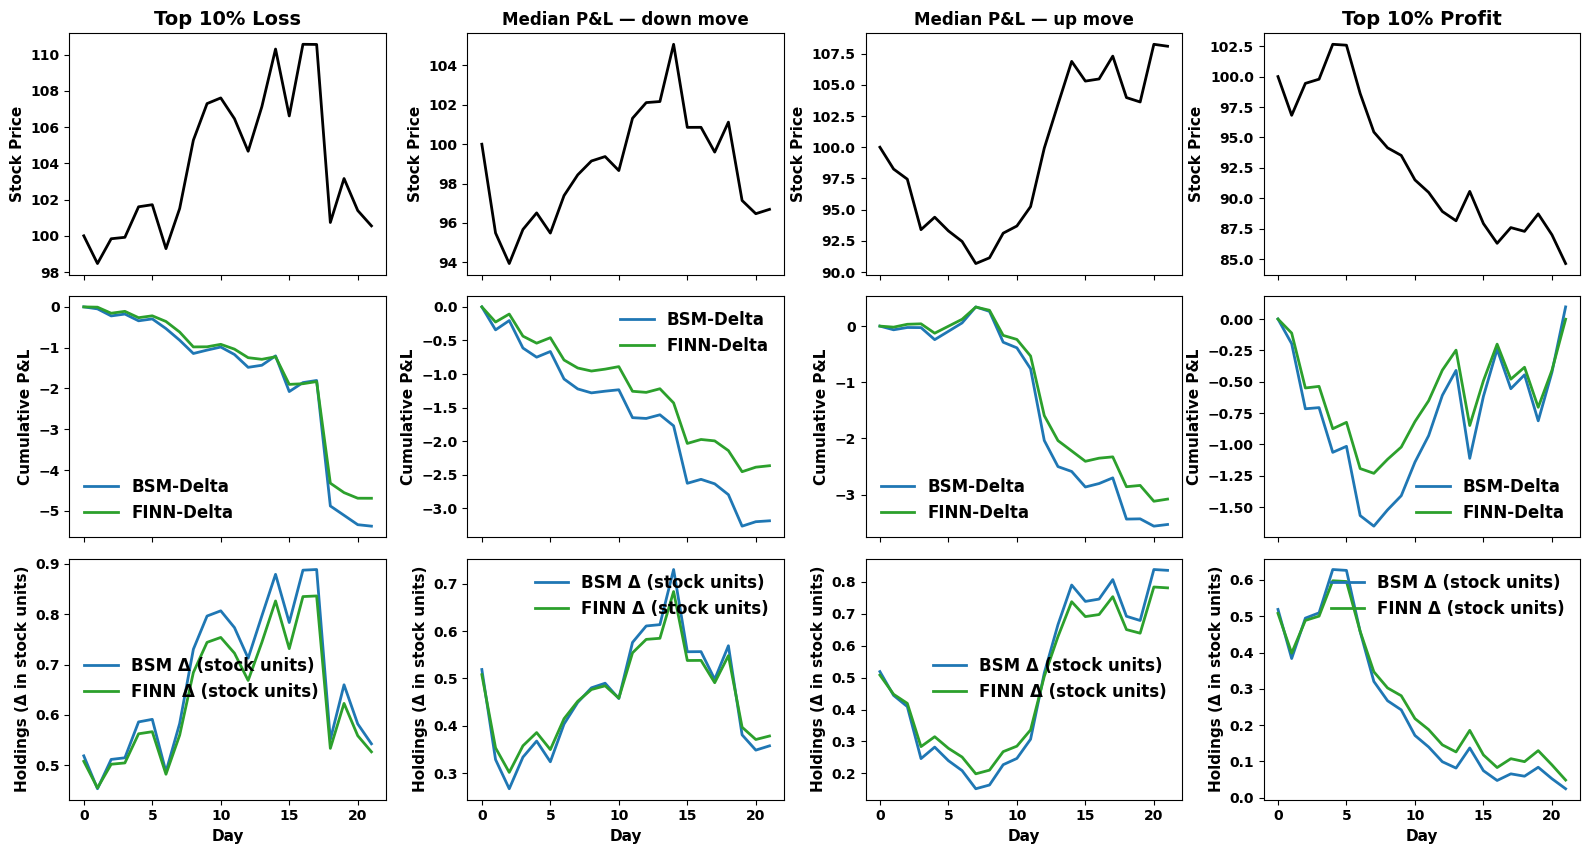

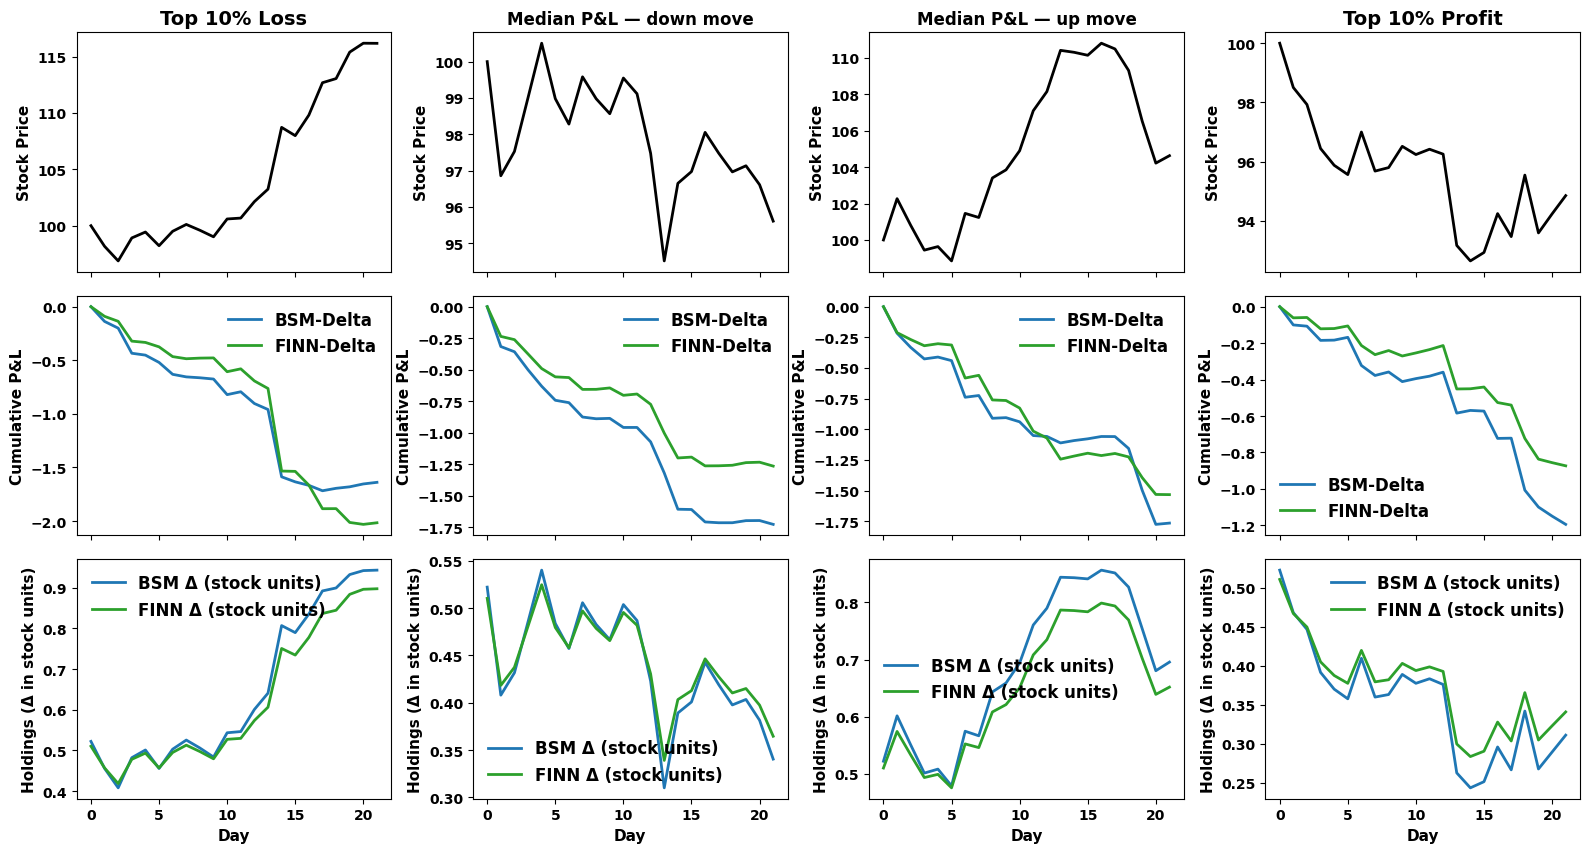

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


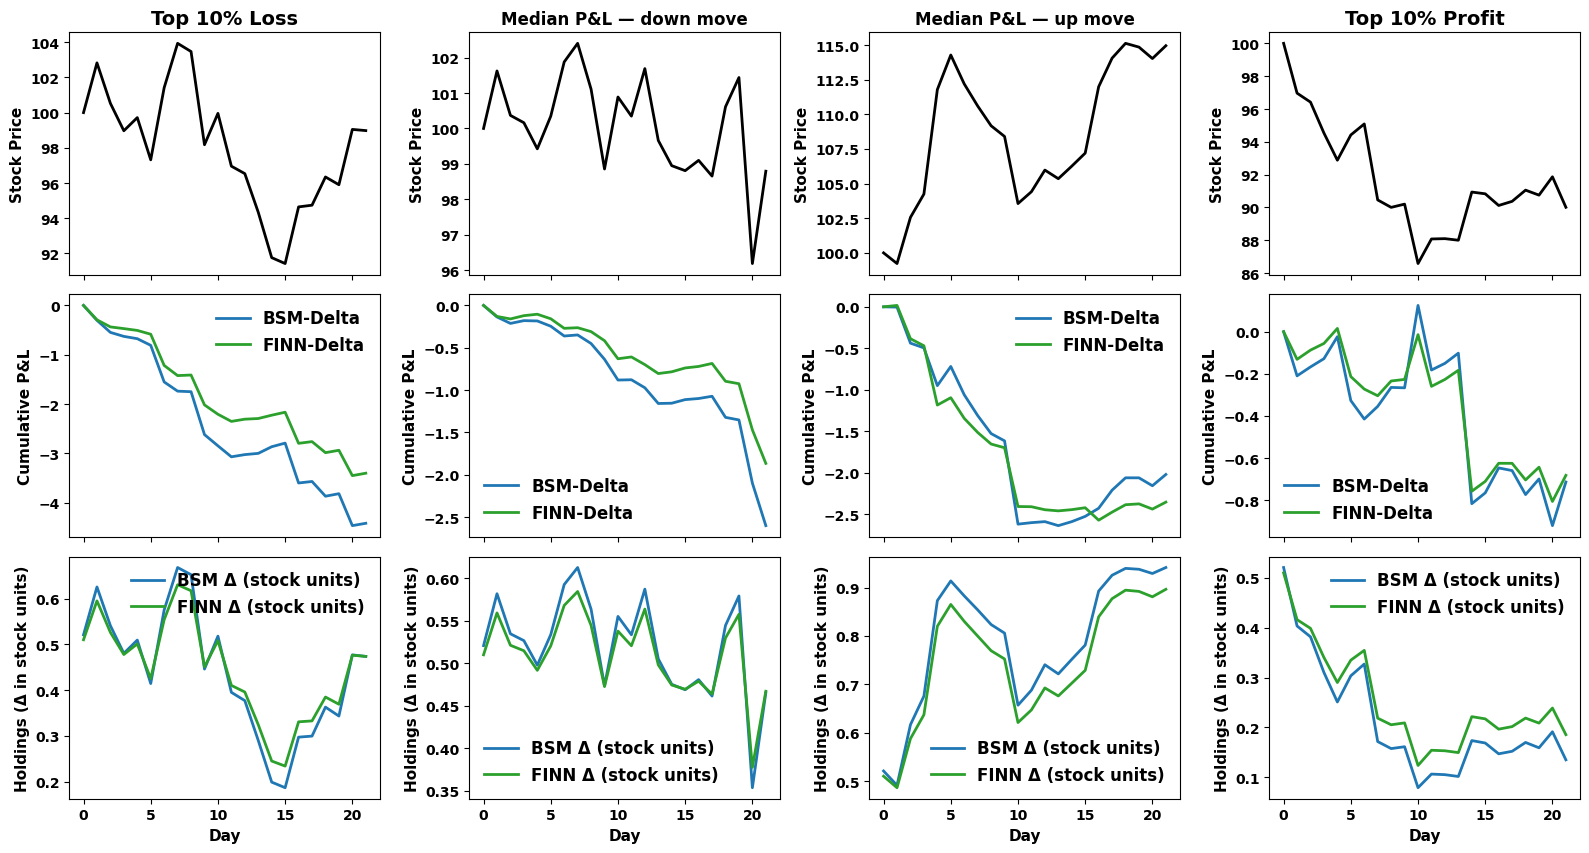

In [ ]:
if __name__ == "__main__":
    for year in [2008, 2011, 2020]:
        for tc in [0.02]:
            panel_mc_example_for_year(
                spx_csv="spx_daily.csv",
                year=year,
                mu_alpha=0.058,
                S0=100.0,
                n_paths=50_000,
                tc=tc,               # stock transaction cost
                seed=494,
                save_path=f"panel_{year}_tc{int(tc*100)}.png",
            )